## Introduction
In this notebook we will preprocess the data for our classification task.<br />
We will train a classifier to predict whether an X-Ray of a patient shows signs of pneumonia or not based on the RSNA Pneumonia Detection Challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge).

At first we download the data from kaggle (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data), by clicking on "Download All" and extract it afterwards.

Acknowledgements:
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

Original Source: https://nihcc.app.box.com/v/ChestXray-NIHCC

## Imports
* pathlib for convenient path handling
* pydicom for reading dicom files
* numpy for storing the actual images
* cv2 for directly resizing the images
* pandas to read the provided labels
* matplotlib for visualizing some images
* tqdm for nice progress bar

In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

At first, we read the csv file containing the labels

In [2]:
labels = pd.read_csv("../Data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")

In [3]:
labels.shape

(30227, 6)

In [4]:
labels.describe

<bound method NDFrame.describe of                                   patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
...                                     ...    ...    ...    ...     ...   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  
0           0  
1           0  
2    

In [5]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Note that subjects may occur multiple times in the dataset because different pneumonia spots are handled indivually. For our classification task, we can remove those duplicates as we are only interested in the binary label.

In [6]:
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")

In [7]:
labels.head(100)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
122,03a9498c-549d-4e7d-800b-e74797f7f625,195.0,511.0,218.0,271.0,1
125,03ab53d0-0a93-43f7-bfb7-4fc5b4db75dc,NaN,NaN,NaN,NaN,0
126,03ae75b6-45a7-4a68-9871-f07b82b17bf6,584.0,367.0,241.0,466.0,1
128,03b10fa5-e7c3-4726-818f-ecbace9da737,NaN,NaN,NaN,NaN,0


Let's define the path to the dicom files and also the path were we want to store our processed npy files

In [8]:
ROOT_PATH = Path("../Data/rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("../Data/rsna-pneumonia-detection-challenge/Processed/")
SAVE_PATH

PosixPath('../Data/rsna-pneumonia-detection-challenge/Processed')

Let's look at some example images

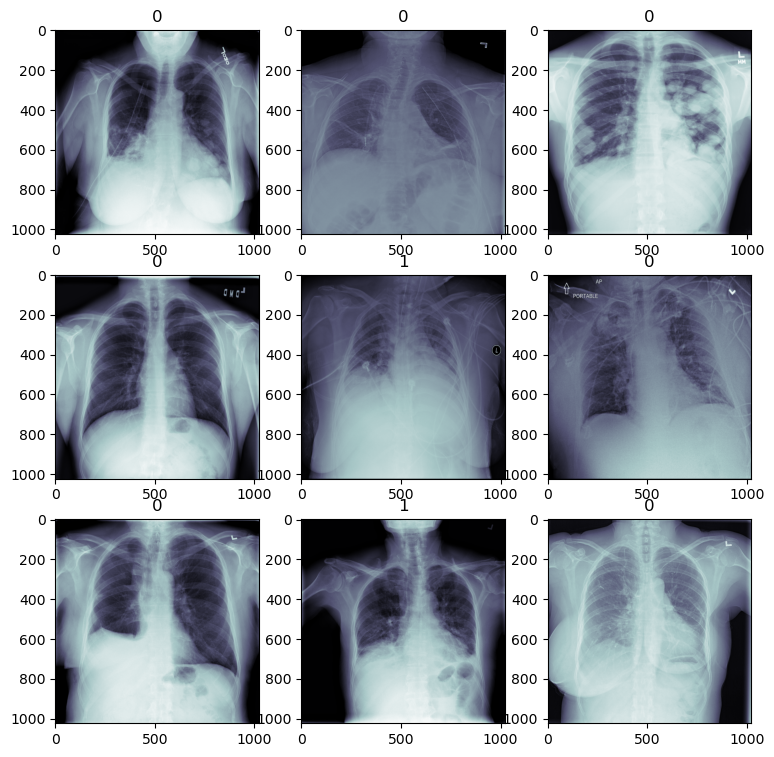

In [9]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.dcmread(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]
        
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

## Dicom Reading & Effective storage

In order to efficiently handle our data in the Dataloader, we convert the X-Ray images stored in the DICOM format to numpy arrays. Afterwards we compute the overall mean and standard deviation of the pixels of the whole dataset, for the purpose of normalization.
Then the created numpy images are stored in two separate folders according to their binary label:
* 0: All X-Rays which do not show signs of pneumonia
* 1: All X-Rays which show signs of pneumonia

To do so, we iterate over the patient ids and concat the patient ID with the ROOT_PATH.

We then directly save the standardized and resized files into the corresponding directory (0 for healthy, 1 for pneumonia).
This allows to take advantage of the ready-to-use torchvision **DatasetFolder** for simple file reading


We standardize all images by the maximum pixel value in the provided dataset, 255.
All images are resized to 224x224.

To compute dataset mean and standard deviation, we compute the sum of the pixel values as well as the sum of the squared pixel values for each subject.
This allows to compute the overall mean and standard deviation without keeping the whole dataset in memory.


In [10]:
sums = 0
sums_squared = 0
im_sum =[]

for c, patient_id in enumerate(tqdm(labels.patientId)):
    # patient_id = labels.patientId.iloc[c]
    # print(patient_id)
    # break 

    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
    
    # Read the dicom file with pydicom and standardize the array
    dcm = pydicom.dcmread(dcm_path).pixel_array / 255  
        
    # Resize the image as 1024x1024 is way to large to be handeled by Deep Learning models at the moment
    # Let's use a shape of 224x224
    # In order to use less space when storing the image we convert it to float16
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    # Retrieve the corresponding label
    label = labels.Target.iloc[c]
    
    # 4/5 train split, 1/5 val split
    train_or_val = "train" if c < 24000 else "val" 
        
    current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory
    
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image   224 x 224

    if train_or_val == "train":  # Only use train data to compute dataset statistics
        # sums += np.sum(dcm_array) / normalizer
        # sums_squared += (np.power(dcm_array, 2).sum()) / normalizer 

        im_sum.append(np.sum(dcm_array)/normalizer)
       

 

  0%|          | 0/26684 [00:00<?, ?it/s]

In [12]:
# ll=np.array(im_sum)
# ll.sum(), sums     # BUG  Sums are capped at 2048.0

In [13]:
np.sum(im_sum), np.mean(im_sum), len(im_sum), im_sum[17]

(np.float16(11770.0), np.float16(0.4905), 24000, np.float16(0.4175))

In [ ]:
N = len(im_sum)   # should be 24000 in this case

# mean = sums / N
# std = np.sqrt(sums_squared / 24000 - (mean**2))   # Theis calculations of std is wrong since (x[i]-mean)^2 != x[i]^2 - mean^2

sums_sq = [(im_sum[i] - np.mean(im_sum))**2 for i in range(len(im_sum))]
std_mg = np.sqrt(np.sum(sums_sq)/N, dtype=np.float64)

print(f"Mean of Dataset: {np.mean(im_sum)}, STD: {std_mg}")


Mean of Dataset: 0.490478515625, STD: 0.08493287072327695
0.4905 0.08493287072327695


In [18]:
len(sums_sq)


24000

We will use mean and std later in the dataloader to normalize our data

In [15]:
print(f"Mean of Dataset: {np.mean(im_sum)}, STD: {std_mg}")

Mean of Dataset: 0.490478515625, STD: 0.0849609375
